In [10]:
import qpms
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
ň = np.newaxis

In [2]:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax2_long.TMatrix'
Wfile = '/u/46/necadam1/unix/qpms/qpms/apps/test/3out'
Wfile_long = '/u/46/necadam1/unix/qpms/qpms/apps/test/3long'
Wfile_short = '/u/46/necadam1/unix/qpms/qpms/apps/test/3short'

In [43]:
#wdata = qpms.loadWfile(Wfile)
wdata = qpms.loadWfile(Wfile_long)
#wdata_short = qpms.loadWfile(Wfile_short)
#wdata_long = qpms.loadWfile(Wfile_long)
TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')

In [44]:
lMax = lMaxTM 
npart = 2
nelem = qpms.get_nelem(lMax)
nomega = 286
nk = 100

In [45]:
# TODO process (interpolate and symmetrize) T-matrix here
wdata['ks'].shape

(28600, 2)

In [46]:
Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
TMatrices = TMatrices_orig.reshape((nomega,1,2,nelem,2,nelem))
ks = wdata['ks'].reshape((nomega,nk,2))
Wmatrices.shape, TMatrices.shape, ks.shape

((286, 100, 2, 2, 8, 2, 2, 8), (286, 1, 2, 8, 2, 8), (286, 100, 2))

In [47]:
TMatrices_orig.shape

(286, 2, 8, 2, 8)

In [48]:
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)

In [49]:
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices[omi,0]
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)))
        except ValueError:
            pass
                

In [33]:
allS[2,59]

array([1.00818944, 1.00659084, 1.00644038, 1.00418299, 1.00410049,
       1.00270136, 1.00069501, 1.0006423 , 1.00063935, 1.00029535,
       1.0002782 , 1.00018558, 1.00000872, 1.00000696, 1.00000198,
       1.00000073, 0.9999838 , 0.99998338, 0.99998123, 0.99997574,
       0.99990113, 0.99980043, 0.99978581, 0.99964436, 0.99964137,
       0.99950072, 0.99669586, 0.99539063, 0.99418467, 0.99354838,
       0.99287275, 0.98487356])

In [29]:
%matplotlib inline

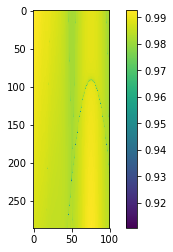

In [35]:
#full
plt.imshow(allS[:,:,-1])
plt.colorbar()

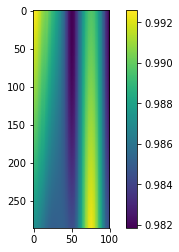

In [42]:
#short
plt.imshow(allS[:,:,-1])
plt.colorbar()

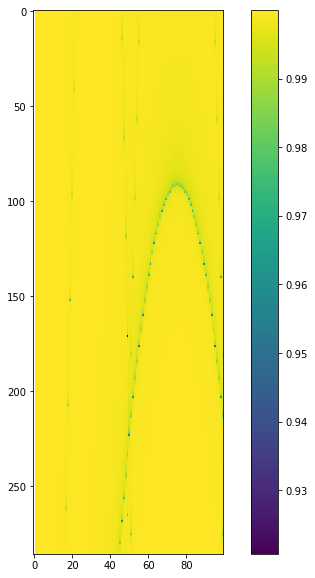

In [53]:
#long
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-1])
plt.colorbar()